In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [139]:
# Importing Libaries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score,mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [113]:
# getting unique files 
Stock_files = os.listdir("/content/drive/MyDrive/assignments/CASE Studies/stock prediction/Data")
Twitter_files = os.listdir("/content/drive/MyDrive/assignments/CASE Studies/stock prediction/twitter")

print(f"The Number Of Unique Stocks and Twitter_sentiments files are {len(Stock_files)} and {len(Twitter_files)} ")

The Number Of Unique Stocks and Twitter_sentiments files are 30 and 30 


In [114]:
# gathering Data

stock_df = pd.DataFrame()

for i in Stock_files:
  stk = i[10:]
  stk_name = i.split(".")[0][15:]
  tw = [j for j in Twitter_files if stk in j]
  df1 = pd.read_csv("/content/drive/MyDrive/assignments/CASE Studies/stock prediction/Data/"+i)
  df2 = pd.read_csv("/content/drive/MyDrive/assignments/CASE Studies/stock prediction/twitter/"+tw[0])
  
  df1 = df1.rename(columns={"Unnamed: 0": "Date"})
  df2 = df2.rename(columns={"Unnamed: 0": "Date"})
  df3 = pd.merge(df1,df2,on="Date",how="left")
  df3["stock_name"] = stk_name 
  
  stock_df = pd.concat([stock_df,df3],axis=0,ignore_index=True)
  # print(stock_df.shape)

print("The shape of Data is ",stock_df.shape)
stock_df.head()

The shape of Data is  (10200, 10)


,Date,HIGH,CLOSE,OPEN,LOW,NUM_NEG,NUM_NEU,NUM_POS,TW,stock_name
0,2013-05-31,55.83,54.61,55.67,54.60,1.0,14.0,1.0,16.0,JPM
1,2013-06-03,54.86,54.48,54.60,53.03,33.0,113.0,41.0,187.0,JPM
2,2013-06-04,55.39,54.03,54.48,53.87,67.0,98.0,19.0,184.0,JPM
3,2013-06-05,54.27,53.03,53.78,52.70,53.0,92.0,10.0,155.0,JPM
4,2013-06-06,53.52,53.50,52.84,52.27,38.0,116.0,16.0,170.0,JPM


In [115]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        10200 non-null  object 
 1   HIGH        9870 non-null   float64
 2   CLOSE       9870 non-null   float64
 3   OPEN        9870 non-null   float64
 4   LOW         9870 non-null   float64
 5   NUM_NEG     10194 non-null  float64
 6   NUM_NEU     10194 non-null  float64
 7   NUM_POS     10194 non-null  float64
 8   TW          10194 non-null  float64
 9   stock_name  10200 non-null  object 
dtypes: float64(8), object(2)
memory usage: 797.0+ KB


#  <font color='green'>EDA</font> 

In [116]:
# Generating Day ,Month ,Year columns
stock_df["day"]=pd.to_datetime(stock_df["Date"]).dt.day
stock_df["month"]=pd.to_datetime(stock_df["Date"]).dt.month
stock_df["year"]=pd.to_datetime(stock_df["Date"]).dt.year
stock_df["Date"]=pd.to_datetime(stock_df["Date"])

In [117]:
# sorting the data w.r.t Date
stock_df.sort_values(by="Date",inplace=True,ignore_index=True)
stock_df

,Date,HIGH,CLOSE,OPEN,LOW,NUM_NEG,NUM_NEU,NUM_POS,TW,stock_name,day,month,year
0,2013-05-31,55.83,54.61,55.67,54.60,1.0,14.0,1.0,16.0,JPM,31,5,2013
1,2013-05-31,92.37,90.49,91.95,90.46,0.0,2.0,0.0,2.0,XOM,31,5,2013
2,2013-05-31,40.77,40.00,40.65,40.00,NaN,NaN,NaN,NaN,KO,31,5,2013
3,2013-05-31,112.21,110.31,110.79,110.30,0.0,1.0,0.0,1.0,MMM,31,5,2013
4,2013-05-31,47.67,46.74,46.92,46.71,0.0,3.0,0.0,3.0,MRK,31,5,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,2014-09-18,49.72,49.70,49.45,49.37,0.0,3.0,0.0,3.0,VZ,18,9,2014
10196,2014-09-18,94.89,94.79,93.94,93.69,0.0,3.0,0.0,3.0,TRV,18,9,2014
10197,2014-09-18,147.06,146.86,145.70,145.69,0.0,4.0,2.0,6.0,MMM,18,9,2014
10198,2014-09-18,216.70,216.10,215.57,215.15,0.0,2.0,0.0,2.0,V,18,9,2014


In [118]:
df=stock_df.drop(columns=["HIGH","OPEN","LOW"],axis=1)

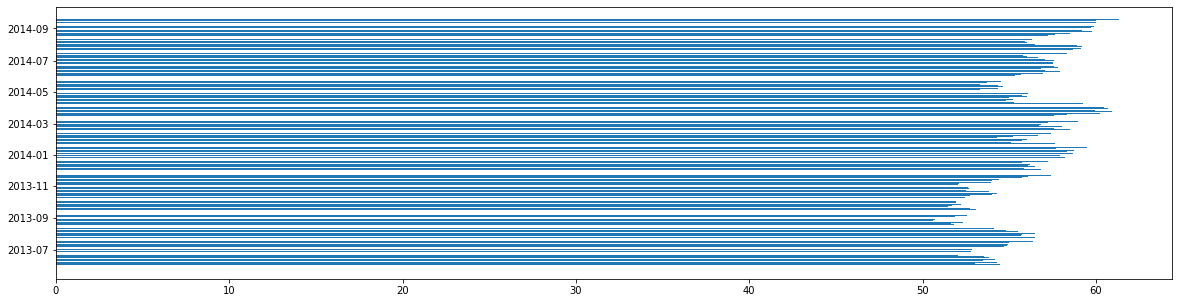

In [119]:
plt.figure(figsize=(20,5))
data=df[df["stock_name"]=="JPM"]
plt.barh(data["Date"],data["CLOSE"])
plt.show()

In [120]:
# droping the Null val
df.dropna(inplace=True)
df.isna().sum()

Date          0
CLOSE         0
NUM_NEG       0
NUM_NEU       0
NUM_POS       0
TW            0
stock_name    0
day           0
month         0
year          0
dtype: int64

In [121]:
x_train = df.iloc[:int(9864*80/100)]
y_train=x_train["CLOSE"]
x_train.drop(columns=["CLOSE","Date"],inplace=True,axis=1)


x_test = df.iloc[int(9864*80/100):]
y_test = x_test["CLOSE"] 
x_test.drop(["CLOSE","Date"],inplace=True,axis=1)

In [125]:
x_train.shape,x_test.shape

((7891, 8), (1973, 8))

In [124]:
# converting Stock_name column to Numerical
le=LabelEncoder()
le.fit(x_train["stock_name"])
x_train["stock_name"]=le.transform(x_train["stock_name"])
x_test["stock_name"]=le.transform(x_test["stock_name"])

In [110]:
x_train

,NUM_NEG,NUM_NEU,NUM_POS,TW,stock_name,day,month,year
0,1.0,14.0,1.0,16.0,13,31,5,2013
1,0.0,2.0,0.0,2.0,29,31,5,2013
3,0.0,1.0,0.0,1.0,16,31,5,2013
4,0.0,3.0,0.0,3.0,17,31,5,2013
7,0.0,5.0,0.0,5.0,10,31,5,2013
...,...,...,...,...,...,...,...,...
8162,3.0,36.0,8.0,47.0,12,17,6,2014
8163,2.0,42.0,13.0,57.0,15,17,6,2014
8164,33.0,268.0,100.0,401.0,18,17,6,2014
8165,1.0,21.0,0.0,22.0,16,17,6,2014


In [141]:
params={'max_depth':[5,10,30,50],
        'min_samples_split':[2,3,5,10],
        'criterion':['mse','mae']}

rf = RandomForestRegressor()

cross_val = RandomizedSearchCV(rf,param_distributions=params ,cv=5 ,n_iter=10,n_jobs=-1,verbose=2)
cross_val.fit(x_train,y_train) 
cross_val.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
rf_best = cross_val.best_estimator_
rf_best.fit(x_train,y_train)

pred = rf_best.predict(X_train)
score=r2_score(y_test,pred)
m_score=mse(y_test,pred)

print(f"The R2_score is ={score} \n The RMSE is {math.sqrt(m_score)} ")

In [143]:
ds=pd.get_dummies(df["stock_name"])

In [144]:
ds

,AXP,BA,CAT,CSCO,CVX,DD,DIS,GE,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,T,TRV,UNH,UTX,V,VZ,WMT,XOM
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10196,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10197,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10198,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


30.399592274206796